# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
raw_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/module 4_1/tweet_sentiment_train.csv.zip')
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
print(raw_df.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [5]:
raw_df[raw_df.isnull().any(axis=1)]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [6]:
raw_df = raw_df.dropna()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [7]:
raw_df[raw_df.isnull().any(axis=1)]

,textID,text,selected_text,sentiment


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



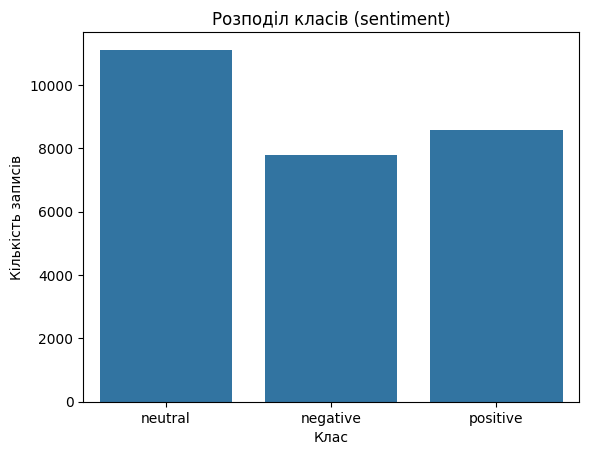

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='sentiment', data=raw_df)
plt.title('Розподіл класів (sentiment)')
plt.xlabel('Клас')
plt.ylabel('Кількість записів')
plt.show()

Найбільше постів мають нейтральний тон. Позитивних постів дещо більше, ніж негативних

In [9]:
raw_df['text_length'] = raw_df['text'].astype(str).apply(len)
print(raw_df['text_length'].describe())

count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64


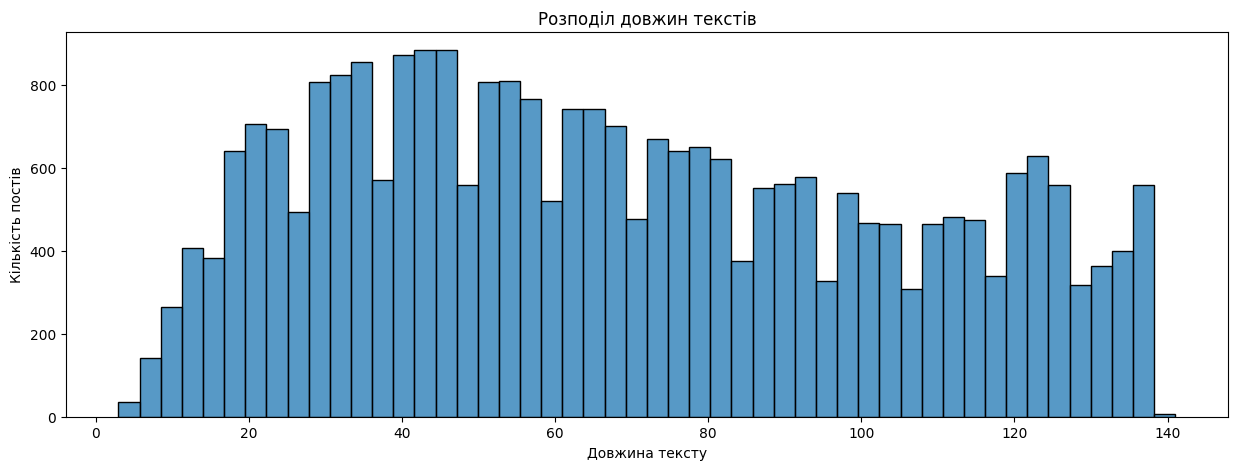

In [10]:
plt.figure(figsize=(15,5))
sns.histplot(raw_df['text_length'], bins=50)
plt.title('Розподіл довжин текстів')
plt.xlabel('Довжина тексту')
plt.ylabel('Кількість постів')
plt.show()

Найбільше постів, які містять 30-50 символів

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [14]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

english_stopwords = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')

nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in english_stopwords and len(word) > 1]
    stems = [stemmer.stem(word) for word in tokens]
    return stems

vectorizer = CountVectorizer(
    tokenizer=preprocess_text,
    lowercase=True,
    max_features=1000
)

X = vectorizer.fit_transform(raw_df['selected_text'])

print("Shape of matrix:", X.shape)
print("Example feature names:", vectorizer.get_feature_names_out()[:20])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Shape of matrix: (27480, 1000)
Example feature names: ['abl' 'absolut' 'access' 'account' 'ach' 'act' 'actual' 'ad' 'add'
 'addict' 'ador' 'afraid' 'afternoon' 'age' 'ago' 'agre' 'ah' 'ahh' 'ahhh'
 'aint']


In [19]:
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
bow_df.head()

,abl,absolut,access,account,ach,act,actual,ad,add,addict,...,yep,yes,yesterday,yet,yo,young,youtub,yum,yummi,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score

y = raw_df['sentiment']
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print("Train size:", X_train_bow.shape)
print("Test size:", X_test_bow.shape)

Train size: (20610, 1000)
Test size: (6870, 1000)


In [23]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}
for name, model in models.items():
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")


 Logistic Regression
Accuracy: 0.7885
F1-score: 0.7893

 Decision Tree
Accuracy: 0.7278
F1-score: 0.7276

 Random Forest
Accuracy: 0.7654
F1-score: 0.7659

 Gradient Boosting
Accuracy: 0.6712
F1-score: 0.6634


Найкращий результат має модель логістичної регресії - вона показує кращий accuracy score i f1 score порівняно з іншими моделями.  
Її точність не можна назвати дуже високою, але загалом результат непоганий і ця модель є корисною

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [24]:
import numpy as np
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

feature_names = np.array(vectorizer.get_feature_names_out())

coefs = pd.DataFrame(model.coef_, columns=feature_names, index=model.classes_)

for sentiment in model.classes_:
    print(f"\nTop 10 influential words for class '{sentiment}':")
    print(coefs.loc[sentiment].sort_values(ascending=False).head(10))

    print(f"\nBottom 10 influential words for class '{sentiment}':")
    print(coefs.loc[sentiment].sort_values(ascending=True).head(10))


Top 10 influential words for class 'negative':
hate      2.332792
sad       2.328949
suck      2.230301
worst     2.213788
miss      2.108002
bore      2.070500
wors      2.055479
fail      2.052746
sorri     2.032002
stupid    1.929023
Name: negative, dtype: float64

Bottom 10 influential words for class 'negative':
love        -2.652529
glad        -2.535587
awesom      -2.524618
thank       -2.369284
hope        -2.004663
beauti      -1.956920
goodnight   -1.862629
welcom      -1.855401
amaz        -1.806198
great       -1.795344
Name: negative, dtype: float64

Top 10 influential words for class 'neutral':
http        1.991634
download    1.660382
differ      1.636133
goin        1.617311
googl       1.508757
exact       1.493203
hannah      1.490545
hello       1.474355
yeah        1.438375
tour        1.437289
Name: neutral, dtype: float64

Bottom 10 influential words for class 'neutral':
excel      -1.265430
relax      -1.197387
wtf        -1.195493
inspir     -1.187993
product 

Загалом важливість слів виглядає досить логічно: топові слова для positive мають позитивний відтінок (любов, подяка, вітання, щастя), для negative - негативний відтінок (ненависть, смуток, провал), а neutral - не мають явного відтінку і не позначають емоції чи відчуття

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_idx, test_idx = train_test_split(raw_df.index, test_size=0.25, random_state=42, stratify=raw_df['sentiment'])

X_train_texts = raw_df.loc[train_idx, 'selected_text']
X_test_texts = raw_df.loc[test_idx, 'selected_text']

y_train = raw_df.loc[train_idx, 'sentiment']
y_test = raw_df.loc[test_idx, 'sentiment']

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=preprocess_text,
    lowercase=True,
    max_features=1000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_test_tfidf = tfidf_vectorizer.transform(X_test_texts)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n{name} (TF-IDF)")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Logistic Regression (TF-IDF)
Accuracy: 0.7898
F1-score: 0.7901

Decision Tree (TF-IDF)
Accuracy: 0.7515
F1-score: 0.7525

Random Forest (TF-IDF)
Accuracy: 0.7799
F1-score: 0.7799

Gradient Boosting (TF-IDF)
Accuracy: 0.6949
F1-score: 0.6838


In [27]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefs = pd.DataFrame(lr_model.coef_, columns=feature_names, index=lr_model.classes_)

for sentiment in lr_model.classes_:
    print(f"\nTop 10 influential words for class '{sentiment}' (TF-IDF):")
    print(coefs.loc[sentiment].sort_values(ascending=False).head(10))

    print(f"\nBottom 10 influential words for class '{sentiment}' (TF-IDF):")
    print(coefs.loc[sentiment].sort_values(ascending=True).head(10))


Top 10 influential words for class 'negative' (TF-IDF):
sad       2.990026
miss      2.891437
hate      2.877252
suck      2.735519
bore      2.447528
fail      2.443668
sorri     2.389417
worst     2.286508
stupid    2.247703
hurt      2.121167
Name: negative, dtype: float64

Bottom 10 influential words for class 'negative' (TF-IDF):
love     -3.585404
thank    -3.155069
lol      -2.944149
glad     -2.678637
awesom   -2.605600
hope     -2.551264
better   -2.276693
haha     -2.212689
morn     -2.129235
amaz     -2.039210
Name: negative, dtype: float64

Top 10 influential words for class 'neutral' (TF-IDF):
http      3.250144
watch     2.410837
yeah      2.162551
check     1.947097
know      1.915124
yet       1.904600
goin      1.891190
differ    1.874578
read      1.834618
lol       1.814771
Name: neutral, dtype: float64

Bottom 10 influential words for class 'neutral' (TF-IDF):
happi    -1.892844
good     -1.612314
nice     -1.371808
relax    -1.254335
fail     -1.253249
wors     -1

Аналогічно до BoW, найкращий результат показала модель логістичної регресії. Метрики accuracy score i f1 score дещо вищі, але загалом дуже близькі до BoW.  
Топ-токени досить схожі до тих, що були отримані при методі B0W.  
Тому загалом можна використовувати обидва типи векторизації, оскільки вони дають дуже близькі результати.


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [31]:
y_pred = lr_model.predict(X_test_tfidf)
errors_df = pd.DataFrame({
    'text': X_test_texts,
    'true_label': y_test,
    'pred_label': y_pred
})
errors_df = errors_df[errors_df['true_label'] != errors_df['pred_label']]
print(f"Кількість помилок: {len(errors_df)}")
errors_df.head(20)


Кількість помилок: 1444


,text,true_label,pred_label
2149,not google friendly,negative,neutral
1454,s not lettin me vote 4 them,negative,neutral
16305,"loves summer! and don`t forget people, tomorro...",positive,neutral
26420,Lol,positive,neutral
3489,seriously im sooooo tired dont know if i`ll su...,negative,neutral
11148,just came bak from dancing with my NEEWWWW cd ...,positive,neutral
9764,still no direct message for me. what the hell ...,negative,neutral
19082,can`t make it to graduation...,negative,neutral
24625,Not sure,negative,neutral
18650,really want to be,positive,neutral


Модель часто оцінює сентимент як нейтральний, який насправді негативний або позитивний. Покращити класифікацію можна так:  
- змінити спосіб токенізації - зараз ми розбивали текст на слова, але так може не завжди уловлюватися контекст, тому може допомогти розбиття на словосполучення
- провести тюнінг гіперпараметрів моделі логістичної регресії (наприклад, змінити регуляризацію, алгоритм оптимізації тощо)
- детальніше пропрацювати видалення шуму і зайвих символів у тексті

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model